[View in Colaboratory](https://colab.research.google.com/github/Milite/Data-Scinece/blob/master/686_Project_Seedlings_Meng_Luo_FINAL.ipynb)

# MSDS686 Project - Plant Seedlings Classification  V1.5
The porject is provided by Kaggle [https://www.kaggle.com/c/plant-seedlings-classification]
Meng Luo, Regis University - Oct 20th, 2018


## Introduction

The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently released a dataset containing images of approximately 960 unique plants belonging to 12 species at several growth stages. The goal of the competition is to create a classifier capable of determining a plant's species from a photo. 

In this final project of MSDS686, we will build CNN models and a predefined model to predict the type of the plants.



## Codes and processes

### Initialization

In this part, we will load models and data.

In [3]:
### Loading in Data using google drive
## REFERENCE https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q#scrollTo=H4SJ-tGNkOeY
# Originally posted in discussion board by Kat. https://worldclass.regis.edu/d2l/le/224600/discussions/threads/1339444/View 

from google.colab import drive

# Prompt for authorization.
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
### Global varibles
dataset_path = "drive/My Drive/Colab Notebooks/Kaggle Data/Plant Seedlings Classification"
runtime_path = dataset_path+ '/runtime'
splitno_path = 4   # How many '/' exists in the dataset path
reduce_scale = 128 # Train with images resized to this many pixels. Used value: 64
#-- reduce_frac  = 0.5 # Train with this fraction of data first to be efficient. Used value: 0.1, 0.5 #Oct 11
#-- aug_ratio    = 2.5 # Aim to have 10000 pictures
seed         = 42  # Set random seed
batch_size   = 50
epoch        = 30

# Note: Environment - Google Colab and AWS: ami-0aa081904a038ad62 ;omdrt=QxiIluNo76tJg?G&u8gd%7Gc$

In [2]:
### Load models
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import math
import random
import os
import glob
import time

from sklearn.model_selection import train_test_split

from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import SGD,adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from keras.layers.advanced_activations import PReLU
## Solution for 'no attribute _name_' error
## RREFERENCE: https://github.com/keras-team/keras/issues/3816 by decaelus. The PReLU solution is posted in the end of this LeakyReLU post.
"""
class PRELU(PReLU):
    def __init__(self, **kwargs):
        self.__name__ = "PRELU"
        super(PRELU, self).__init__(**kwargs)
"""



Using TensorFlow backend.


'\nclass PRELU(PReLU):\n    def __init__(self, **kwargs):\n        self.__name__ = "PRELU"\n        super(PRELU, self).__init__(**kwargs)\n'

In [0]:
### Create dataset 
## REFERENCE: https://www.kaggle.com/vanausloos/how-to-read-images-in-python; https://www.kaggle.com/nikkonst/plant-seedlings-with-cnn-and-image-processing
train_path=dataset_path+"/train"
labels = os.listdir(train_path)
classno = len(labels) #12 classes 
encode_map ={k: v for k, v in zip(labels,list(range(1,classno+1)))}
train_files = glob.glob(train_path+'/*/*.png')
train_labels = [f.split('/')[splitno_path+2] for f in train_files]


## Loading images
train_im = []
j=0
for im in train_files:
    train_im.append(cv2.resize(cv2.imread(im), (reduce_scale, reduce_scale)))  # Get image (with resizing)
    j += 1


### Explortary Data Analysis
Check the size of the training data and whether it is imbalanced. It turns out acceptable (221~654 images). We should consider data augmentation since this is a small dataset.

In [0]:
len(train_files) # 4750 photos in the training set.
sns.countplot(train_labels); 

(128, 128, 3)

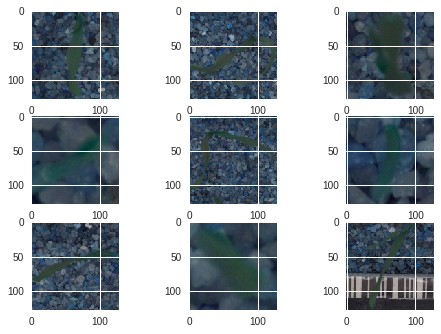

In [11]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_im[i]) #Looking good

train_im[21].shape

### Image processing

1. Should we use mask or greyscale? See discussion board. 
 - I chose to use only use a green color mask here because greyscale doesn't help with my first simple CNNs model.
 - Reference: https://www.kaggle.com/nikkonst/plant-seedlings-with-cnn-and-image-processing
2. Process and normalize datasets, including encoding categorical labels with one-hot approach.   
3. Data augmentation is necessary it time allows to increase the training data size.



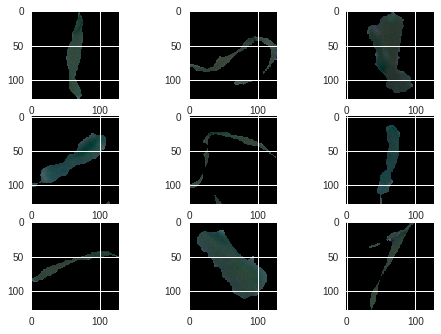

In [7]:
### 1. Create a mask for green areas
train_im_masked = [];
for i in train_im:
    blurr = cv2.GaussianBlur(i,(5,5),0) # Use gaussian blur
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV) # Convert to HSV image
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8) # Create empty image
    new[boolean] = i[boolean] # Apply boolean mask to the origin image
    train_im_masked.append(new) # Append the image without background
      
for i in range(9): # Check the results
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_im_masked[i])

In [0]:
### 2. Create final datasets
train_masked_df = pd.DataFrame({'im':train_im_masked,'label':train_labels})  
train_masked_df.label=train_masked_df.label.replace(encode_map)-1  
X_train = np.array(train_im_masked).astype( 'float32' )/255 # normalization
Y_train = to_categorical(train_masked_df.label) #onehot encoding

### Save files and models

This is not included in the course assignments or most of the codes available online. However, it turns out a critical part for this multiple-week project to save files, models at will and automatically by creating checkpoints. Kat provided this solution in the MSDS686 discussion board. Thanks Kat!

In [0]:
### Saving files and weights
## REFERENCE Kat mentioned in the discussion board. Original from http://www.astrobetter.com/blog/2013/07/29/python-tip-storing-data/ 

np.save(runtime_path+'/train_im', train_im)
np.save(runtime_path+'/train_im_masked',train_im_masked)
np.save(runtime_path+'/X_train', X_train)
np.save(runtime_path+'/Y_train',Y_train)
np.save(runtime_path+'/test_im', test_im)
np.save(runtime_path+'/test_im_masked',test_im_masked)
np.save(runtime_path+'/X_test', X_test)





In [0]:
### Create checkpoints for later callbacks

filepath=runtime_path+'/weights_best'+time.strftime("%m%d%H")+'-{epoch:02d}_{val_acc:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')    

filepath=runtime_path+'weights_last_auto'+time.strftime("%m%d%H")+'.hdf5'
checkpoints_all = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

callbacks_list = [checkpoint, checkpoints_all] 

### Models

1. Simple CNN model with 3 units
2. Altered CNN models with data augmentation, learning rate decay, and others.
3. MobileNet transfer learning model with predefined weights

#### Model 1: Deep CNN with 3 units
This model is built based on the code frame of MSDS686 MNIST assignment solution by Dr Geena Kim. 

AfterI some trail and errors, I set its basic unit as conv-batchnorm-conv-maxpool-batchnorm-dropout.  For dropout rate, I am not using the default 0.5 for this hyperparameter, because in this model a Batch Normalization layer is after every Conv2D layer. 

In [9]:
### Create model1
def unit(model, n_filter=32, init=False):
    if init:
        model.add(Conv2D(32,2,activation='relu',input_shape=(reduce_scale,reduce_scale,3),padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(64,2,activation='relu',padding='same'))
    else:   
        model.add(Conv2D(n_filter,2,activation='relu',padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(n_filter,2,activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3)) 
    return model

def model1_deep_cnn(n):
    model=Sequential()
    model = unit(model,init=True)
    if n>1:
        for i in range(1, n):
            model=unit(model,n_filter=64)       
    model.add(Flatten())
    model.add(Dense(32, activation= 'relu'))
    model.add(Dense(classno, activation= 'softmax')) 
    return model 

model1 = model1_deep_cnn(n=3)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      416       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        16448     
__________

In [0]:
### Train model1
lr = 0.0005 # Tried values without decent results in first 10 epochs: 0.0001, 0.0001, 0.002
decay = lr/epoch
model1.compile(loss= 'categorical_crossentropy', optimizer= keras.optimizers.adam(lr=lr,decay=decay), metrics=['accuracy'])
hist_train = model.fit(X_train, Y_train, epochs=epoch, validation_split=0.2, callbacks=callbacks_list, batch_size=batch_size)  

In [0]:
### Plot out model1
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train history for Model 1')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    legendLoc = 'lower right' if(train=='acc') else 'upper right'
    plt.legend(['train', 'validation'], loc=legendLoc)
    plt.show()

show_train_history(hist_train, 'acc', 'val_acc')


In [0]:
### Process the test dataset
test_path = dataset_path+"/test"
test_files = glob.glob(test_path+'/*.png')
test_names = [f.split('/')[splitno_path+2] for f in test_files]

test_im=[]; j=0
for im in test_files:
    print(j+1)
    test_im.append(cv2.resize(cv2.imread(im), (reduce_scale, reduce_scale)))  # Get image (with resizing)
    j += 1
    
test_im_masked = [];
for i in test_im:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8) 
    new[boolean] = i[boolean] 
    test_im_masked.append(new) 
"""
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_im_masked[i]) #Looking good
"""    
X_test = np.array(test_im_masked).astype('float32')/255 # Normalization

#-- X_test.shape

In [0]:
### Prediction and submission
bestmodel=keras.models.load_model('weights_best-01_0.8854.hdf5')
Y_test = bestmodel.predict_classes(X_test)
#-- Y_test 

Y_test = Y_test +1
inv_map= {v : k for k, v in encode_map.items()}

y_test = [];i=0
for file in test_names:
    y_test.append(inv_map[Y_test[i]])
    i+=1
submission = pd.DataFrame({'file': test_names, 'species': y_test})

## Submission
submission.to_csv(dataset_path+'/result/submission_'+time.strftime("%m%d-%H%M")+'.csv', index=False)

#### Model 2: CNN models with data augmentation, learning rate decay, and other alternatives
Now that we have our first working model with Kaggle submission score of 0.4433, let's revisit data augmentation. The main reason I believe this technique will improve the performance is that current data set is too small (4750 images) for deep learning. We are aiming at least 10000 images here, therefor the aug_ratio is set to 2.5.

Optimizaer SGD and learning rate decay/scheduler will be used and discussed here as well.

In [0]:
### Reloading data - Model 2
## Note: I tried PReLU here, the model stopped learning after 5 epoches. So the final model is built with relu.
"""
train_im =np.load(runtime_path+'/train_im.npy')
train_im_masked =np.load(runtime_path+'/train_im_masked.npy')
X_train =np.load(runtime_path+'/X_train.npy')
Y_train =np.load(runtime_path+'/Y_train.npy')
test_im =np.load(runtime_path+'/test_im.npy')
test_im_masked =np.load(runtime_path+'/test_im_masked.npy')
test_names = np.load(runtime_path+'/test_names.npy')
X_test =np.load(runtime_path+'/X_test.npy')
classno = 12 
encode_map={'Black-grass': 3,
 'Charlock': 5,
 'Cleavers': 4,
 'Common Chickweed': 7,
 'Common wheat': 1,
 'Fat Hen': 2,
 'Loose Silky-bent': 8,
 'Maize': 6,
 'Scentless Mayweed': 9,
 'Shepherds Purse': 10,
 'Small-flowered Cranesbill': 11,
 'Sugar beet': 12}

def unit(model, n_filter=32, init=False):
    if init:
        model.add(Conv2D(32,2,input_shape=(reduce_scale,reduce_scale,3),padding='same'))
        model.add(PReLU.())
        model.add(BatchNormalization())
        model.add(Conv2D(64,2,activation='relu',padding='same'))
    else:   
        model.add(Conv2D(n_filter,2,padding='same'))
        model.add(PReLU.())
        model.add(BatchNormalization())
        model.add(Conv2D(n_filter,2,activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3)) 
    return model

def model2_deep_cnn(n):
    model=Sequential()
    model = unit(model,init=True)
    if n>1:
        for i in range(1, n):
            model=unit(model,n_filter=64)       
    model.add(Flatten())
    model.add(Dense(32, activation= 'relu'))
    model.add(Dense(classno, activation= 'softmax')) 
    return model 
"""

In [0]:
### 1. Data Augmentaion
### REFERENCE: https://chtseng.wordpress.com/2018/01/19/kaggle-%E7%99%BC%E8%8A%BD%E6%A4%8D%E7%89%A9%E5%88%86%E9%A1%9E/
aug_ratio = 2.5 # Aim to have 10000 pictures

(X_train2, X_val2, Y_train2, Y_val2) = train_test_split (X_train, Y_train, test_size=0.2, random_state=seed)

train_datagen = ImageDataGenerator(
    zoom_range = 0.1,
    shear_range = 0.5,
    height_shift_range = 0.1,
    width_shift_range = 0.1,
    rotation_range = 10) 

val_datagen = ImageDataGenerator(
    zoom_range = 0.1,
    shear_range=0.5,
    height_shift_range = 0.1,
    width_shift_range = 0.1,
    rotation_range = 10) 

train_generator = train_datagen.flow(X_train2, Y_train2, batch_size=batch_size)
val_generator = val_datagen.flow(X_val2, Y_val2, batch_size=batch_size)

In [13]:
### 2. New callbacks and model with learning rate scheduler and decay
def step_decay(epoch): # learning rate drops gradually
    initial_lrate = 0.1
    drop = 0.5 
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)
callbacks_list2 = [checkpoint, lrate, checkpoints_all]

model2= model1_deep_cnn(n=3)
model2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 32)      416       
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 64)      8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        16448     
__________

In [21]:
### Training the CNN model with data augmentation. 
lr = 0.0002 #0.0005 seems too slow, while 0.002 and 0.005 apparently result overfitting.
decay = lr/epoch
model2.compile(loss= 'categorical_crossentropy', optimizer= keras.optimizers.adam(lr=lr,decay=decay), metrics=['accuracy'])

hist_train2 = model2.fit_generator(train_generator,steps_per_epoch=100, epochs=epoch, callbacks=callbacks_list2, validation_data=val_generator)   

result_path = dataset_path+'/result'
np.save(result_path+'/hist_train2'+time.strftime("%m%d-%H%M")+ hist_train2)



Epoch 1/30
100/100 [==============================] - 797s 8s/step - loss: 2.2465 - acc: 0.8520 - val_loss: 2.5367 - val_acc: 0.8418

Epoch 00001: val_acc improved from 0.17368 to 0.84175, saving model to drive/My Drive/Colab Notebooks/Kaggle Data/Plant Seedlings Classification/runtime/weights_best102013-01_0.8418.hdf5

Epoch 00001: saving model to drive/My Drive/Colab Notebooks/Kaggle Data/Plant Seedlings Classification/runtimeweights_last_auto102013.hdf5
Epoch 2/30
100/100 [==============================] - 792s 8s/step - loss: 2.5135 - acc: 0.8432 - val_loss: 2.5367 - val_acc: 0.8418

Epoch 00002: val_acc did not improve from 0.84175

Epoch 00002: saving model to drive/My Drive/Colab Notebooks/Kaggle Data/Plant Seedlings Classification/runtimeweights_last_auto102013.hdf5
Epoch 3/30
100/100 [==============================] - 790s 8s/step - loss: 2.5290 - acc: 0.8422 - val_loss: 2.5367 - val_acc: 0.8418

Epoch 00003: val_acc improved from 0.84175 to 0.84175, saving model to drive/My D

NameError: ignored

In [0]:
np.save(result_path+'/hist_train_aug'+time.strftime("%m%d-%H%M"), hist_train_aug.history)

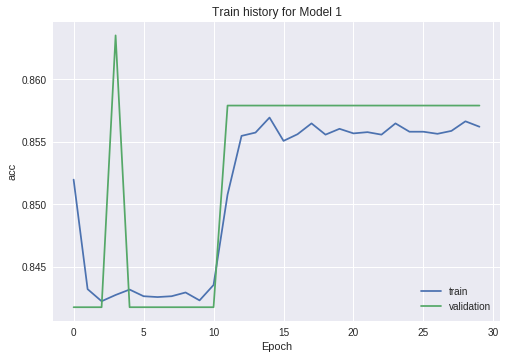

In [27]:
### Plot out Model
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train history for Model 1')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    legendLoc = 'lower right' if(train=='acc') else 'upper right'
    plt.legend(['train', 'validation'], loc=legendLoc)
    plt.show()

show_train_history(hist_train_aug, 'acc', 'val_acc')

This diagram shows the last 30 epoches with val_acc varries between 0.8418~0.8635. It shows the model is "stable" but it could also mean that the model has stop learning, being over-fitted or predicting some images wrong all the time. Let's submit the result again.

In [0]:

### Prediction and submission
bestmodel=keras.models.load_model('drive/My Drive/Colab Notebooks/Kaggle Data/Plant Seedlings Classification/runtime/weights_best102013-04_0.8635.hdf5')
Y_test = bestmodel.predict_classes(X_test)
Y_test 

Y_test = Y_test +1
inv_map= {v : k for k, v in encode_map.items()}

y_test = [];i=0
for file in test_names:
    y_test.append(inv_map[Y_test[i]])
    i+=1
submission = pd.DataFrame({'file': test_names, 'species': y_test})

### Submission
submission.to_csv(dataset_path+'/result/submission_'+time.strftime("%m%d-%H%M")+'.csv', index=False)


The result sheet itself appears normal, but the Kaggle score is just 0.1788 

#### Discussion - CNN models

The score of the above CNN with data augmentation is only 0.1788, albeit val_acc=0.8635.I also tried using PReLU, loss=binary_crossentropy or optimizers=SGD with momentum. The final Kaggle score got lower although the val_acc gets higher (Val_acc gets up to 0.9387, while Kaggle score stay below 0.30). Even after I restarted the runtime on Colab, in case we were training some of the same weights, the score is 0.2884 still not as good as the simple Model 1.

It shows an overfit over vadilication data. Or data augmentation doesn't work well with deep CNN models. Some key statements for other variations are:
 - model1_aug_bin.compile(loss= 'categorical_crossentropy', optimizer= keras.optimizers.SGD(lr=0.0005,momentum=0.9), metrics=['accuracy'])
 - model1_aug_bin.compile(loss= 'categorical_crossentropy', optimizer= keras.optimizers.SGD(lr=0.0005,momentum=0.9), metrics=['accuracy'])


The best score of these various of CNN models so far is 0.4432.


#### Model 3 - MobileNet with predefined weights for ImageNet

We will deploy Transfer Learning here with a small model MobileNet will ImageNet weights. The main technoniques it uses are 1X1 conv filters for its "expansion" and "projection" layers.


Considering computing efficiency, we will use a GlobalAveragePooling2D layer instead of Flatten before the Dense FC layers in the end. The latter is 3 times more expensive. The altered model with our own top layers has 3.3 million parameters among 96 layers. 

Google has also released the 2nd version of MobileNet, called MobileNetV2. It includes linear bottlenecks between the layers and shortcut connections between the bottlenecks to achieve better performanc and accuracy. However we cannot import it with the current Keras version provided by Colab.


REFERENCES:

https://keras.io/applications/

https://github.com/keras-team/keras/issues/8470

https://arxiv.org/pdf/1704.04861.pdf

https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html


In [0]:
### Reloading data - Model 3
train_im3 = []
j=0
for im in train_files:
    print(j)
    train_im3.append(cv2.resize(cv2.imread(im), (224,224)))  # Get image (with resizing)
    j += 1

for i in range(9): # Check the results.We are using resized pictures without green masking, since data in ImageNet is not masked.
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_im3[i])
    
X_train3 = np.array(train3_im).astype( 'float32' )/255 # normalization
Y_train3 =np.load(runtime_path+'/Y_train.npy')

np.save(runtime_path+'/X_train3', X_train3)

test_path = dataset_path+"/test"
test_files = glob.glob(test_path+'/*.png')
test_im3=[]; j=0
for im in test_files:
    test_im.append(cv2.resize(cv2.imread(im), (224,224)))  # Get image (with resizing)
    j += 1
X_test3 = np.array(test_im3).astype('float32')/255 # Normalization
np.save(runtime_path+'/X_test3', X_test3)

"""
X_train3 =np.load(runtime_path+'/X_train3.npy')
Y_train3 =np.load(runtime_path+'/Y_train.npy')
test_names = np.load(runtime_path+'/test_names.npy')
classno = 12 
encode_map={'Black-grass': 3,
 'Charlock': 5,
 'Cleavers': 4,
 'Common Chickweed': 7,
 'Common wheat': 1,
 'Fat Hen': 2,
 'Loose Silky-bent': 8,
 'Maize': 6,
 'Scentless Mayweed': 9,
 'Shepherds Purse': 10,
 'Small-flowered Cranesbill': 11,
 'Sugar beet': 12}
 
filepath=runtime_path+'/weights_best'+time.strftime("%m%d%H")+'-{epoch:02d}_{val_acc:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')    

filepath=runtime_path+'weights_last_auto'+time.strftime("%m%d%H")+'.hdf5'
checkpoints_all = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

callbacks_list = [checkpoint, checkpoints_all] 
"""

In [7]:
### Build a new model
### REFERENCE https://keras.io/applications/
from keras.applications import mobilenet #  Can't load the mobilenetv2 package.
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

model3_base=mobilenet.MobileNet(input_shape= (224,224,3), include_top=False, weights='imagenet')
x = model3_base.output
x = GlobalAveragePooling2D()(x) #GlobalAveragePooling2D vs Flatten, see Chollet's comment at https://github.com/keras-team/keras/issues/8470
x = Dense(64, activation='relu')(x)
predictions = Dense(12, activation='softmax')(x)

# The new model to train. Notice that they are using the Functional API to train the predefinedd and new layers separately.
model3 = Model(inputs=model3_base.input, outputs=predictions)
model3.summary()
# Total layers: 96 13 units * 7 layers + 5 top layers.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

In [9]:
### Train the model - New bottom layers

for layer in model3.layers:
    layer.trainable = True
for layer in model3_base.layers:
    layer.trainable = False

model3.compile(optimizer=adam(lr=0.001), loss='categorical_crossentropy',  metrics=['accuracy'])

base_hist = model3.fit(X_train3, Y_train3, epochs=3, validation_split=0.2, callbacks=callbacks_list, batch_size=batch_size)

base_hist2 = model3.fit(X_train3, Y_train3, epochs=10, validation_split=0.33, callbacks=callbacks_list, batch_size=2*batch_size)

Train on 3182 samples, validate on 1568 samples
Epoch 1/10
3182/3182 [==============================] - 579s 182ms/step - loss: 0.3565 - acc: 0.8859 - val_loss: 6.8583 - val_acc: 0.0013

Epoch 00001: val_acc did not improve from 0.04000

Epoch 00001: saving model to drive/My Drive/Colab Notebooks/Kaggle Data/Plant Seedlings Classification/runtimeweights_last_auto102117.hdf5
Epoch 2/10
3182/3182 [==============================] - 587s 184ms/step - loss: 0.3079 - acc: 0.9001 - val_loss: 7.1187 - val_acc: 6.3776e-04

Epoch 00002: val_acc did not improve from 0.04000

Epoch 00002: saving model to drive/My Drive/Colab Notebooks/Kaggle Data/Plant Seedlings Classification/runtimeweights_last_auto102117.hdf5
Epoch 3/10
3182/3182 [==============================] - 594s 187ms/step - loss: 0.2844 - acc: 0.9092 - val_loss: 6.8587 - val_acc: 0.0032

Epoch 00003: val_acc did not improve from 0.04000

Epoch 00003: saving model to drive/My Drive/Colab Notebooks/Kaggle Data/Plant Seedlings Classificati

KeyboardInterrupt: ignored

In [10]:
# To train the top 2 blocks. 
for layer in model3.layers[:19]:
    layer.trainable = True
for layer in model3.layers[19:]:
    layer.trainable = False
    
# we need to recompile the model for these modifications to take effect
# Tried SGD and lr=0.0001 as provided by Keras in default, it is too low for us.)
model3.compile(optimizer=adam(lr=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

hist_train3 = model3.fit(X_train3, Y_train3, epochs=10, validation_split=0.2, callbacks=callbacks_list, batch_size=batch_size)
result_path = dataset_path+'/result'
np.save(result_path+'/hist_train3'+time.strftime("%m%d-%H%M"), hist_train3)


Train on 3800 samples, validate on 950 samples
Epoch 1/10
3800/3800 [==============================] - 1955s 515ms/step - loss: 0.4798 - acc: 0.8516 - val_loss: 12.6638 - val_acc: 0.0000e+00

Epoch 00001: val_acc did not improve from 0.04000

Epoch 00001: saving model to drive/My Drive/Colab Notebooks/Kaggle Data/Plant Seedlings Classification/runtimeweights_last_auto102117.hdf5
Epoch 2/10
3800/3800 [==============================] - 1937s 510ms/step - loss: 0.4206 - acc: 0.8724 - val_loss: 12.8374 - val_acc: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.04000

Epoch 00002: saving model to drive/My Drive/Colab Notebooks/Kaggle Data/Plant Seedlings Classification/runtimeweights_last_auto102117.hdf5
Epoch 3/10
3800/3800 [==============================] - 1936s 510ms/step - loss: 0.3921 - acc: 0.8745 - val_loss: 12.9983 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve from 0.04000

Epoch 00003: saving model to drive/My Drive/Colab Notebooks/Kaggle Data/Plant Seedlings

KeyboardInterrupt: ignored

In [0]:
### New submission
## Reference https://github.com/keras-team/keras/issues/4875
X_test3 =np.load(runtime_path+'/X_test3.npy')
test_names =np.load(runtime_path+'/test_names.npy')

from keras.utils.generic_utils import CustomObjectScope 
with CustomObjectScope({'relu6': keras.applications.mobilenet.relu6,'DepthwiseConv2D': keras.applications.mobilenet.DepthwiseConv2D}):
    bestmodel=keras.models.load_model('drive/My Drive/Colab Notebooks/Kaggle Data/Plant Seedlings Classification/runtimeweights_last_auto102117.hdf5')

Y_test3 = bestmodel.predict(X_test3)
Y_test3 = Y_test3.argmax(axis=-1) +1

inv_map= {1: 'Common wheat',
 2: 'Fat Hen',
 3: 'Black-grass',
 4: 'Cleavers',
 5: 'Charlock',
 6: 'Maize',
 7: 'Common Chickweed',
 8: 'Loose Silky-bent',
 9: 'Scentless Mayweed',
 10: 'Shepherds Purse',
 11: 'Small-flowered Cranesbill',
 12: 'Sugar beet'}
#-- {v : k for k, v in encode_map.items()}

y_test3 = [];i=0
for file in test_names:
    y_test3.append(inv_map[Y_test3[i]])
    i+=1
submission = pd.DataFrame({'file': test_names, 'species': y_test3})

### Submission
submission.to_csv(dataset_path+'/result/submission_'+time.strftime("%m%d-%H%M")+'.csv', index=False)


In [1]:
Y_train

NameError: ignored

#### Discussion - Altered MobileNet model 

Comparing to the first 2 models, the thrid performs very bad. One of the reasons is that I don't have enough resource to try different combinations of hyperparameters and new layer options - The training time for one epoch is between 10~30mins. More importantly, I think I need to read more papaers on the optimizers and losses. I am wondering if I have choose a wrong metric because the val_acc, acc and final Kaggle score don't really align with each other.

Reasons it fails other than but being optimized are:

*   Unmasked data: I assumed the original image will perform better since ImageNet inputs are not masked. That assumption could be wrong.
*   Small dataset: I didn't balance, randomize or augmentation the datasize, being afraid that turning too much training time with more data. However, it also means that I didn't take the advantage of the power of big data size.
*   Unknown error: although I checked all the data head and format before I feed them to the next step, there is a chance that the data is presented wrong. There might also be better optimizers to choose from.



## Conclusion

With CNN models and MobileNet models, We achieved a maxium Kaggle score of 0.4432 for this image classification challenge. This project helps me understand how different models and hyperparameters will affect the result and the importance of image -preprocessing, pre-defined weights and computation power. Here are some main points for future attempts to improve the results:

*   Train other models such as Xception with a more powerful machine.
*   Try it with other data augmentation, blurring and masking options. 
*   Combine results from different models to produce new prediction.
